Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-5d023d5b1c97>:64: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["TEMP_lag1"] = weather["TEMP_lag1"].fillna(method="bfill")
<ipython-input-1-5d023d5b1c97>:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["AIRP_lag1"] = weather["AIRP_lag1"].fillna(method="bfill")
<ipython-input-1-5d023d5b1c97>:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["HUMI_lag1"] = weather["HUMI_lag1"].fillna(method="bfill")
<ipython-input-1-5d023d5b1c97>:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["SOLA_lag1"] = weather["SOLA_lag1"].fillna(method="bfill")
<ipython-input-1-5d023d5b1c97>:74: FutureWarning: Se

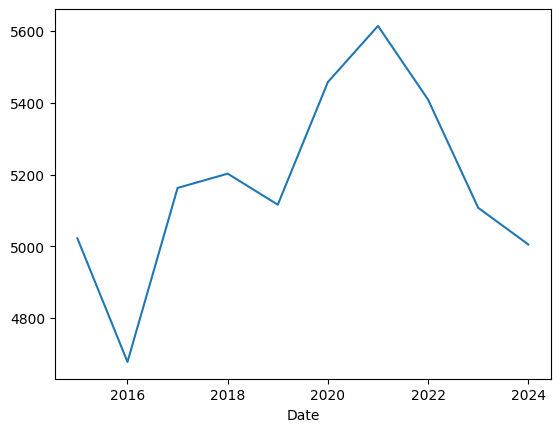

In [1]:
# -*- coding: utf-8 -*-
"""WeatherPredictionHK.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Z_DdI7ED_0NVDZOm8o4M8VRpefTWUUZr
"""
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
weather = pd.read_csv('/content/drive/MyDrive/hkdailyweather.csv', index_col="Date") ## import data


"""TEMP = Mean Temperature (°C) - King's Park
HUMI = Mean Relative Humidity (%) - King's Park
RAIN = Total Rainfall (mm) - King's Park
WIND = Mean Wind Speed (km/h) - King's Park
AIRP = Daily Mean Pressure (hPa) at the Hong Kong Observatory
SOLA = Global Solar Radiation (MJ/m²) - King's Park
SUNH = Total Bright Sunshine (hours) - King's Park
"""

weather["TEMP"].value_counts()  ## To check the count of each data point
weather["HUMI"].value_counts()  ## if too little count, may not be useful or relevant
weather["SUNH"].value_counts()

"""If value is missing, we may need to fill back data, since ML does not work well with missing value. A forward fill approach or depending situation, fill the most likely data"""

weather.dtypes # check data type, must need be numerical

weather = weather.apply(pd.to_numeric, errors='coerce').astype(float) # convert all to float type

weather.dtypes

weather.apply(pd.isnull).sum()/weather.shape[0] ## data cleaning : look for null value, 0 mean all value exist

weather["TEMP"] = weather["TEMP"].fillna(0)   # fill in all null value
weather["HUMI"] = weather["HUMI"].fillna(0)
weather["RAIN"] = weather["RAIN"].fillna(0)
weather["WIND"] = weather["WIND"].fillna(0)

weather.apply(pd.isnull).sum()/weather.shape[0] ## data cleaning : look for null value, 0 mean all value exist

weather.index # check data type, convert to data time index using pandas function

weather.index = pd.to_datetime(weather.index) # convert to data time index using pandas function

weather.index



weather.groupby(weather.index.year).sum() # Data of each year

weather.groupby(weather.index.year).apply(lambda x: x["SOLA"].sum()).plot() # Data of each year

# add lag function
weather["TEMP_lag1"] = weather["TEMP"].shift(1)
weather["AIRP_lag1"] = weather["AIRP"].shift(1)
weather["HUMI_lag1"] = weather["HUMI"].shift(1)
weather["SOLA_lag1"] = weather["SOLA"].shift(1)

weather["TEMP_lag1"] = weather["TEMP_lag1"].fillna(method="bfill")
weather["AIRP_lag1"] = weather["AIRP_lag1"].fillna(method="bfill")
weather["HUMI_lag1"] = weather["HUMI_lag1"].fillna(method="bfill")
weather["SOLA_lag1"] = weather["SOLA_lag1"].fillna(method="bfill")

# add rolling average
window_size = 7 # 7 day rolling average

weather["TEMP_rolling_mean"] = weather["TEMP"].rolling(window=window_size, min_periods=1).mean()
weather["TEMP_rolling_std"] = weather["TEMP"].rolling(window=window_size, min_periods=1).std()
weather["TEMP_rolling_mean"] = weather["TEMP_rolling_mean"].fillna(method="bfill")
weather["TEMP_rolling_std"] = weather["TEMP_rolling_std"].fillna(method="bfill")

# add combine features
weather["SOLA_SUNH"] = weather["SOLA"] * weather["SUNH"]  # Effective solar energy
weather["SOLA_SUNH"] = weather["SOLA_SUNH"].fillna(method="ffill")

# difference features
# change in air pressure may imply temperature change
weather["AIRP_diff"] = weather["AIRP"].diff()
weather["AIRP_diff"] = weather["AIRP_diff"].fillna(method="bfill")

weather["target"] = weather.shift(-1)["TEMP"] # To predict the weather tmr

weather = weather.iloc[:-1,:].copy()  # remove the last row

from sklearn.ensemble import RandomForestRegressor  # Random Forest regression
reg = RandomForestRegressor(
    n_estimators=200,      # Number of trees
    max_depth=15,          # Maximum depth of each tree
    max_features="sqrt",   # Use sqrt(number of features) for each split
    oob_score=True,        # Enable out-of-bag error
    random_state=42        # For reproducibility
)

predictors = ["TEMP", "HUMI", "RAIN", "WIND", "AIRP", "SOLA", "SUNH", "TEMP_lag1", "AIRP_lag1", "HUMI_lag1", "SOLA_lag1", "TEMP_rolling_mean", "TEMP_rolling_std", "SOLA_SUNH", "AIRP_diff"]

train = weather.loc[:"2020-12-31"]
test = weather.loc["2021-01-01":]

reg.fit(train[predictors], train["target"]) # fit model to data set

predictions = reg.predict(test[predictors])


In [2]:
reg.fit(train[predictors], train["target"]) # fit model to data set

predictions = reg.predict(test[predictors])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(test["target"], predictions)
mae = mean_absolute_error(test["target"], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test["target"], predictions)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# 2.023280569698605

Mean Absolute Error (MAE): 1.0446
Mean Squared Error (MSE): 2.0233
Root Mean Squared Error (RMSE): 1.4224
R-squared (R²): 0.9203


In [3]:
# Out-of-bag score (if available)
print(f"OOB Score: {reg.oob_score_}")



OOB Score: 0.9151429811767053



Feature Importance:
              Feature  Importance
0                TEMP    0.295900
11  TEMP_rolling_mean    0.167977
7           TEMP_lag1    0.155456
4                AIRP    0.132099
8           AIRP_lag1    0.103394
12   TEMP_rolling_std    0.031479
5                SOLA    0.021624
14          AIRP_diff    0.016269
10          SOLA_lag1    0.016091
1                HUMI    0.015628
13          SOLA_SUNH    0.012857
6                SUNH    0.008699
9           HUMI_lag1    0.008540
3                WIND    0.008134
2                RAIN    0.005853


,actual,predictions,diff
Date,,,
2024-01-22,7.0,15.129961,8.129961
2021-01-07,8.1,15.506986,7.406986
2023-12-16,12.4,19.092033,6.692033
2024-02-29,12.4,18.609484,6.209484
2023-01-15,11.5,17.497124,5.997124
2023-12-15,18.0,23.915821,5.915821
2022-10-17,20.1,25.794716,5.694716
2022-04-30,19.7,25.258882,5.558882
2021-11-07,19.4,24.933804,5.533804


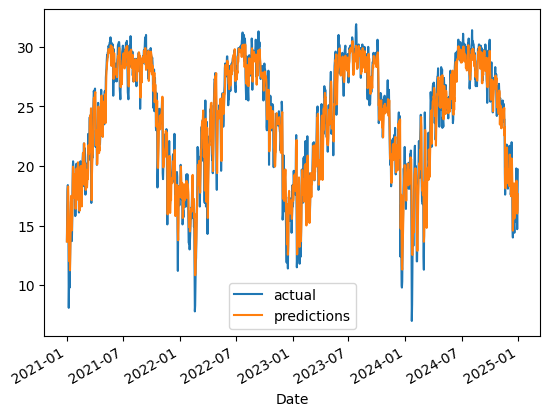

In [4]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': predictors,
    'Importance': reg.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]

combined.plot()

weather.corr()["target"]  # correlation

combined["diff"] = (combined["actual"] - combined["predictions"]).abs()

combined.sort_values("diff", ascending=False).head(10)